# 1. EEG Dataset Preprocessing

Scope:
- Process a raw EEG dataset & produce a results superset
- Dataset containing the results of an EEG study on multiple subjects
- Dataset that has been downloaded from OpenNeuro, and structured as per the BIDS standard, and in EEGLab '.set' format

The Stages (For each subject in an EEG study dataset):
- EEG Dataset Load - Get the raw source EEG signal data
- EEG Preprocessing - Execute filtering etc of the raw EEG time series data
- Power Spectra (PSD) Calculate - Calculate the power spectra, for all channels recorded
- Spectral Parameterisation - Determine the best fitting Aperiodic and Periodic components
- Results Superset - Collate & save the study, subject and EEG data into a results set, Pandas Dataframe


## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- specparam = 2.0.0rc3

## Python-MNE

Used for Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io

EEG Data Format for Processing:
- In FIF format (Functional Image File Format): https://www.perplexity.ai/search/having-read-some-eeg-data-usin-70hxIA1KSZu6VdV.MfLY_A

Used for Power Spectrum Calculate
- MNE vs NeuroDSP: https://www.perplexity.ai/search/using-python-which-package-is-zOoiPqUvTnKbO.QfgmPsJQ

Formats:
- Assumes OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure
- Assumes EEGLab '.set' format


## Spectral Parameterisation

Spectral Parameterisation:
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Documentation:
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools
- FOOOF: https://fooof-tools.github.io/fooof/ and https://github.com/fooof-tools/fooof

FOOOF vs SpecPram:
- FOOOF: More stable and used but deprecated
- SpecParam: Release candidate but some improved model/fit selection: https://pmc.ncbi.nlm.nih.gov/articles/PMC11326208/
- Summary: https://www.perplexity.ai/search/using-python-which-package-is-M7kzhERoTLuCrIKbXxN9sQ


# Imports & Utilities

In [1]:
# Not availble through a Conda install/environment - PIP Install may be required
# %pip install specparam


In [2]:
# General imports
import os
import sys
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle
import random

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra
from specparam import __version__ as specparam_version
print('Current SpecParam version:', specparam_version)


Current SpecParam version: 2.0.0rc3


In [21]:
# Print and also to add to a PDF file
#

def print_with_pdf(text, pdf_file):

    # Normal print
    print(text)

    # Text added to a PDF
    plt.figure(figsize=(12, 1))
    plt.axis('off') 
    # plt.text(0.01, 0.99, text, fontsize=14, va='top', ha='left', wrap=True, weight='bold')
    plt.text(0.01, 0.99, text, fontsize=14, va='top', ha='left', wrap=True)
    pdf_file.savefig()
    plt.close()


# Classes & Functions

## Get Raw EEG data

In [4]:
# Function to get the raw EEG signal data
#

def get_EEG_raw(dataset_path, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    dataset_path : str
    subject_id : str

    Returns
    -------
    EEG_raw : FIF
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # Cater for none or multiple sessions, eg 'ses-01', 'ses-02'
    temp_path = os.path.join(dataset_path, subject)
    subfolders = [f for f in os.listdir(temp_path) if os.path.isdir(os.path.join(temp_path, f))]
    if 'eeg' in subfolders:
        session = ''
    elif any(f.startswith('ses-') for f in subfolders):
        session = sorted([f for f in subfolders if f.startswith('ses-')])
    else:
        raise FileNotFoundError(f"No 'eeg' or session folder found in {temp_path}")
    
    # Cater for 0 or multiple sessions
    # print(f'Test Found: {session}')
    sessions_eeg_raw = []
    if session == '':
        temp_path = os.path.join(dataset_path, subject, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
        try:
            eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
            sessions_eeg_raw.append(eeg_dataset_raw)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    else:
        for next_session in session:
            temp_path = os.path.join(dataset_path, subject, next_session, datatype)
            temp_file_name = subject + '_' + next_session + '_task-' + task + '_' + datatype + '.set'
            eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
            # print(f'Test session path: {eeg_lab_file_path}')
            try:
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
            except Exception as e:
                raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    
    return sessions_eeg_raw

In [5]:
# Function to plot EEG Time Series
def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    start = (time_range_s[0] * 500) if time_range_s else 0
    stop = (time_range_s[1] * 500) if time_range_s else 999999


    # Get signal and times for the elected channel(s)
    signal, times = eeg_FIF.get_data(picks=channels, 
                                     start=start, stop=stop,
                                     return_times=True)
    # signal = np.squeeze(signal)

    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

## EEG Preprocessing

In [6]:
# Function to preprocess the raw EEG signal data
def perform_EEG_preprocessing(preprocess_params, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    preprocess_params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_filtered = EEG_raw.copy()

    # -----------------------------------------------------------------------
    # Bandpass filtering
    #
    EEG_filtered = EEG_filtered.filter(picks='eeg', 
                                       l_freq=preprocess_params['band_pass_lf'], 
                                       h_freq=preprocess_params['band_pass_hf'], 
                                       method=preprocess_params['band_pass_method'], 
                                       phase='zero', 
                                       verbose=flag_verbose)

    # -----------------------------------------------------------------------
    # Montage Set
    # Attempt to use standard-1020 channels, but remove any channels not in it
    #
    std_1020_montage = mne.channels.make_standard_montage("standard_1020")
    std_1020_montage.plot()
    # Identify missing channels & drop them
    raw_set = set(EEG_raw.ch_names)
    montage_set = set(std_1020_montage.ch_names)
    missing_in_raw = montage_set - raw_set
    print(f"Channels in montage but not in EEG_raw: {sorted(missing_in_raw)}")
    missing_in_montage = raw_set - montage_set  
    print(f"Channels in EEG_raw but not in montage: {sorted(missing_in_montage)}")
    EEG_filtered.drop_channels(missing_in_montage)
    # Set to standard montage and plot
    EEG_filtered.set_montage(std_1020_montage)
    print(f"Number of channels before: {len(EEG_raw.ch_names)} and after montage set: {len(EEG_filtered.ch_names)}")
    fig = EEG_filtered.plot_sensors(show_names=True)
    plt.show()

    # -----------------------------------------------------------------------
    # Remove linear trends from each channel signal & average
    #
    if preprocess_params['linear_detrend']:
        EEG_filtered.apply_function(sci.signal.detrend, n_jobs=-1, channel_wise=True, type='linear', verbose=flag_verbose)

    # Execute average referencing
    EEG_filtered.set_eeg_reference(ref_channels=preprocess_params['channel_referencing'], verbose=flag_verbose)

    return EEG_filtered


## Artifact Removal - ICA

In [7]:
# Function to perform artifact removal using ICS
def perform_artifact_removal(preprocess_params, EEG_raw):
    """
    Artifact removal on the EEG raw data, using ICA

    Parameters
    ----------
    preprocess_params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_cleaned = EEG_raw.copy()

    # Determine ICA components
    ica = ICA(n_components=len(EEG_cleaned.ch_names) - 1, 
              max_iter="auto", 
              method=preprocess_params['ica_method'], 
              random_state=42, 
              fit_params=dict(extended=True))
    ica.fit(EEG_cleaned, verbose=flag_verbose)

    if flag_verbose:
        # Look at the results
        explained_var_ratio = ica.get_explained_variance_ratio(EEG_cleaned)
        for channel_type, ratio in explained_var_ratio.items():
            print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

        explained_var_ratio = ica.get_explained_variance_ratio(EEG_cleaned, components=[0], ch_type="eeg")
        ratio_percent = round(100 * explained_var_ratio["eeg"])
        print(f"Fraction of variance in EEG signal explained by first component: "
            f"{ratio_percent}%")

        ica.plot_overlay(EEG_cleaned, exclude=[0], picks="eeg")
 
    # Label and identify ICA components for exclusion
    ica_labels = label_components(EEG_cleaned, ica, method='iclabel')
    labels = ica_labels["labels"]
    brain_components = [i for i, label in enumerate(labels) if label == "brain"]
    other_coponents = [i for i, label in enumerate(labels) if label != "brain"]
    print(f'ICA Components: {ica.n_components_}. Brain: {len(brain_components)} and other: {len(other_coponents)} ')

    print(other_coponents)
    
    # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING
    return EEG_cleaned


## Get the Power Spectra

In [8]:
# Function to get the power spectra from the cleaned/preprocessed EEG signal data
def get_spectra(psd_params, EEG_clean):
    """
    Obtain the Power Spectra for all channels

    Parameters
    ----------
    psd_params : dic
    EEG_clean : clean

    Returns
    -------
    Spectra : frequencies and powers for each channel
    """
    try:
        spectra_result = EEG_clean.compute_psd(method=psd_params['method'],
                                               fmin=psd_params['fmin'],
                                               fmax=psd_params['fmax'],
                                               exclude=psd_params['exclude'])
    except Exception as e:
        raise Exception(f"Error calculating spectra: {e}")

    return spectra_result


In [9]:
# Function to plot EEG Frequncy Domain / PSD
def plot_EEG_PSD(spectra, channel):
    """
    EEG Frequency Domain / PSD Plot.

    Parameters
    ----------
    spectra : mne.Spectrum
    channel : str eg 'P5'
    """

    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    print('Quick PSD')
    spectra.plot()
    plt.show()

    # Log-log plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
        plt.loglog(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Log) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # Log-lin plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
         plt.semilogy(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Lin) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # A selected channel
    ch_label = channel
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(f'Power Spectrum - Channel {ch_label} ({spectra.method} method)', fontsize=20)
    ax0.set_title('Log/Log')
    ax1.set_title('Log/Lin')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')
    plt.show()


## Spectral Parameterisation

In [10]:
# Function to perform Spectral Parameterisation and dtermine the aperiodic and periodic components
def perform_SpecParam(specparam_params, spectra):
    """
    Spectral Parameterisation to determine the aperiodic and periodic components for all channels

    Parameters
    ----------
    specparam_params : dic
    spectra : spectra

    Returns
    -------
    specparam_df : dataframe of components for each channel
    fg : SpectralGroup Model

    """

    # Initialise SpecParam Group Model & fit it
    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    spm_fit_freq_range = [1, 75]

    try:
        fg = SpectralGroupModel(peak_width_limits=specparam_params['peak_width_limits'], 
                                max_n_peaks=specparam_params['max_n_peaks'], 
                                min_peak_height=specparam_params['min_peak_height'],
                                peak_threshold=specparam_params['peak_threshold'],
                                aperiodic_mode=specparam_params['aperiodic_mode'])
        fg.fit(freqs, powers, specparam_params['fit_freq_range'], progress='tqdm.notebook')
    except Exception as e:
        raise Exception(f"Error performing SpecParam: {e}")

    specparam_df = fg.to_df(specparam_params['max_n_peaks'])    

    # TODO: Validity checks?
    # TODO: Eg some subjects have 66 channels .. trim to 64 or reject the subject ... warning message?    
    
    return specparam_df, fg


In [11]:
# Function to plot SpecParam Results
def plot_SpecParam(fg, channel_indx, channel_name):
    """
    EEG SpecParam Results Plot

    Parameters
    ----------
    fg : SpecParamGroupModel
    """
    fm = fg.get_model(ind=channel_indx, regenerate=True)
    fm.print_results()

    # fm.plot()
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    fig.suptitle(f'Spec Param for Channel: {channel_name}', fontsize=20)
    ax0.set_title('Components - Log/Lin')
    ax1.set_title('Components - Log/Log')
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
    plt.show()


## Results Collate

In [12]:
# Collate Results for a subject
def subject_features_collate(subject_details, specparam_results_df):
    """
    Results features collate for an indvidual subject

    Parameters
    ----------
    subject_details : pd series
    specparam_results_df : df
    Returns
    -------
    subject_features_df: df (single row)
    """

    # TODO: Combine results eg total average, by region etc .... ??

    subject_features_df = pd.DataFrame()
    # Subject Details Add
    subject_features_df = pd.concat([subject_features_df, pd.DataFrame([subject_details])], ignore_index=True)

    # Results Add
    rows = [subject_features_df]
    for idx, row in specparam_results_df.iterrows():
        row_df = pd.DataFrame([row.values], columns=[f'chn_{idx}_{col}' for col in row.index])
        rows.append(row_df)
    subject_features_df = pd.concat(rows, axis=1, ignore_index=False)

    return subject_features_df

# Study & Run Parameters Define

In [13]:
# EEG Pipeline Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
study_name = 'IOWA_Rest'
dataset_ref = 'ds004584-1.0.0'
# study_name = 'UNM_Oddball'
# dataset_ref = 'ds003490-1.1.0'

# Run/Test Mode
test_mode = True

# Execution Parameters
run_summary = 'trial_preprocess'
preprocess_params = {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero',
                     'linear_detrend': True,
                     'channel_referencing': 'average',
                     'ica_method': 'infomax'
                     }
psd_params = {'method': 'welch', 
              'fmin': 1, 'fmax': 250,       
              'exclude': []  # Includes all, even bad channels
              }
specparam_params = {'peak_width_limits': [1, 12],
                    'max_n_peaks': 10,
                    'min_peak_height': 0.1,
                    'peak_threshold': 2.0,
                    'aperiodic_mode': 'fixed',
                    'fit_freq_range' : [1, 75]
                     }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
dataset_path = study_info_df.loc[0, 'dataset_path']
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Establish a new EEG Processing Run
current_date = datetime.now().strftime('%Y%m%d')
eeg_run_id = f'EEG_Processing_{dataset_ref}_{current_date}_{run_summary}'
eeg_processing_run_path = utils.extend_folder_path(eeg_processing_results_path, eeg_run_id, exists_ok=False)
results_pdf = PdfPages(os.path.join(eeg_processing_run_path, 'results.pdf'))

# Create run df and save
eeg_run_params_df = pd.DataFrame({
    'eeg_run_id': [eeg_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'preprocess_params': [preprocess_params],
    'psd_params': [psd_params],
    'specparam_params': [specparam_params],
})
eeg_run_params_df.to_pickle(eeg_processing_run_path + '/eeg_run_params_df.pkl', compression='zip')

# Create empty study results
eeg_results_superset_df = pd.DataFrame()

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    max_subjects_run = 2
    test_channels = ['P5', 'C4', 'Cz']
else:
    VERBOSE = False
    max_subjects_run = np.inf
    test_channels = []

del current_date, eeg_processing_results_path

# Execute EEG Processing Run

EEG Processing for: IOWA_Rest ds004584-1.0.0. Run: trial_preprocess

Preprocessing Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': True, 'channel_referencing': 'average', 'ica_method': 'infomax'}

-----------------------------------------------------------------------------------------------

Subject: sub-001

--Get EEG Raw Data - FIT-----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-001/eeg/sub-001_task-Rest_eeg.fdt
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Description: None on None
<RawEEGLAB | sub-001_task-Rest_eeg.fdt, 63 x 140830 (281.7 s), ~67.8 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 n

/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_6746/988434826.py:46: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


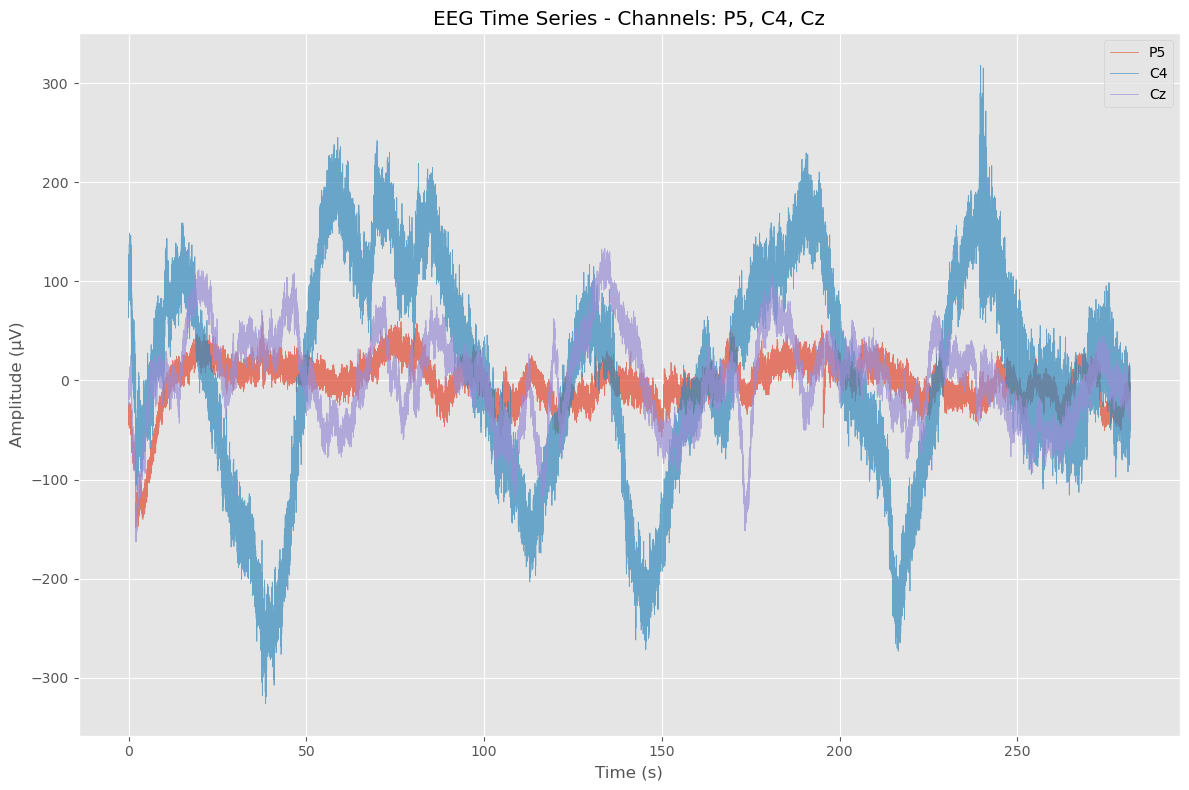


--Preprocessing EEG----------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


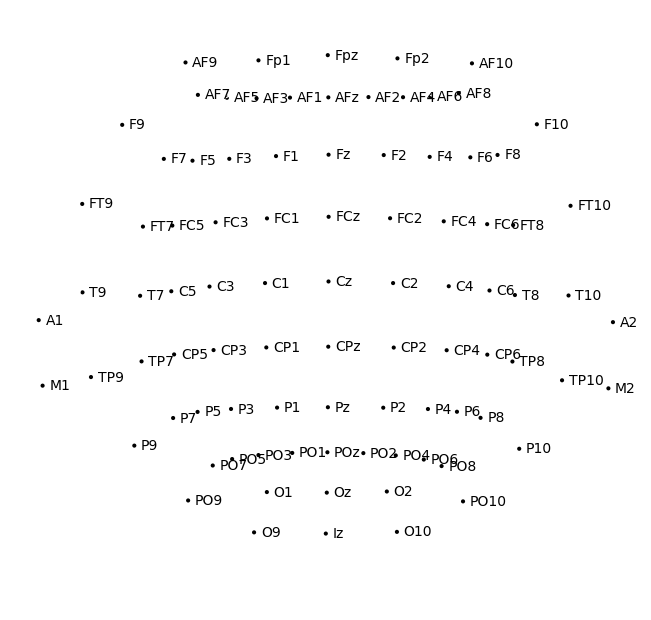

Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


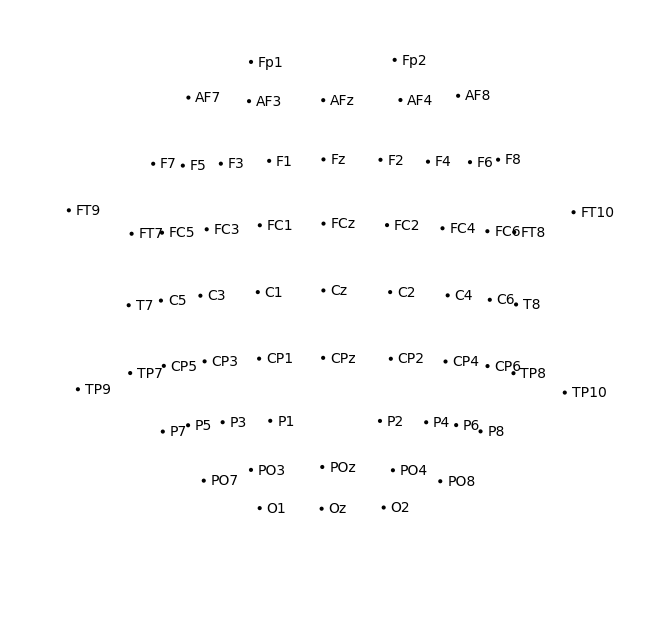

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    0.6s finished


Filtered EEG Signal


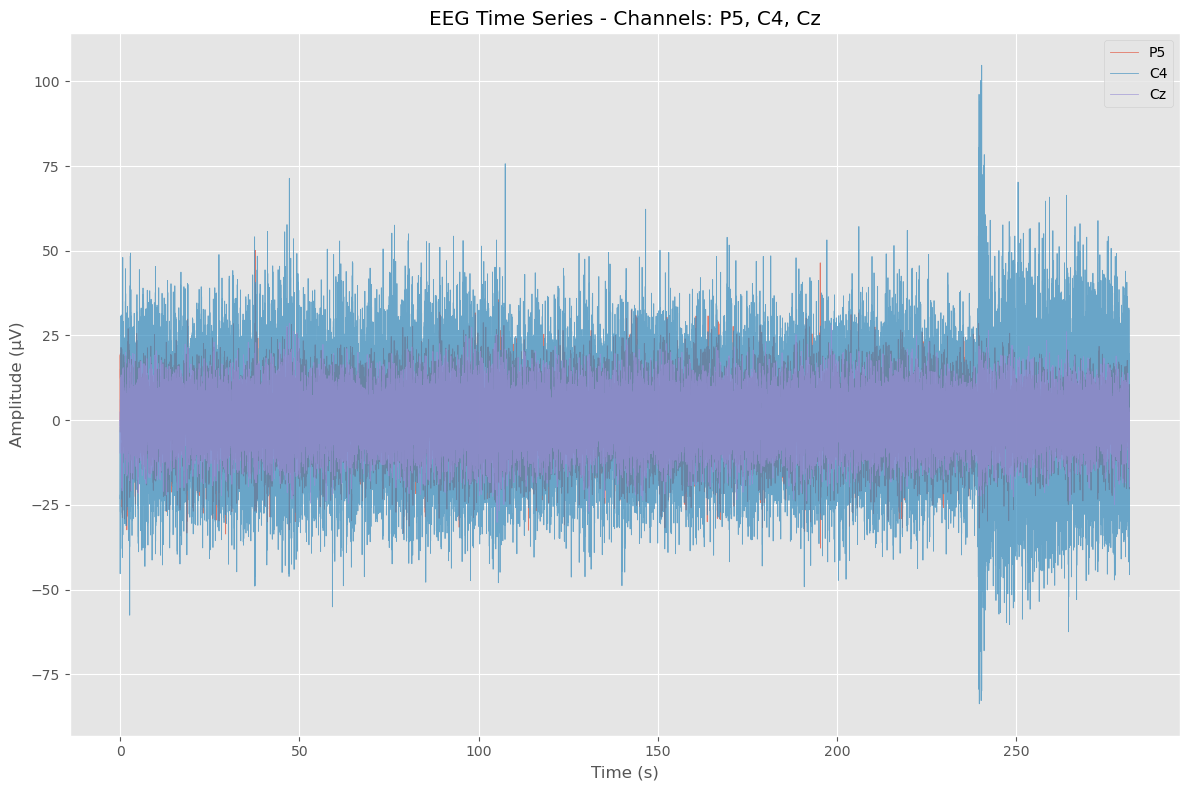

In [ ]:
# Execute all the preprocessing steps for each subject
#

if VERBOSE:
    summary = f'EEG Processing for: {study_name} {dataset_ref}. Run: {run_summary}'
    summary = summary + f'\n\nPreprocessing Params: {preprocess_params}'
    print_with_pdf(summary, results_pdf)

for idx, subject in study_subjects_df.iterrows():

    # Break if a test run
    if int(idx) > (max_subjects_run - 1):
        break

    subject_id = subject['subject_id']

    if VERBOSE:
        print('\n-----------------------------------------------------------------------------------------------')
        print_with_pdf(f'\nSubject: {subject_id}', results_pdf)

    # 1. EEG Raw Dataset Load
    #
    if VERBOSE:
        print('\n--Get EEG Raw Data - FIT-----------------------------------------')

    EEG_raw_files = get_EEG_raw(dataset_path, subject_id)
    # TODO: How to handle multiple session EEG raw files?
    temp_EEG_raw = EEG_raw_files[0]
    if VERBOSE:
        print(f"Description: {temp_EEG_raw.info['description']} on {temp_EEG_raw.info['meas_date']}")
        print(temp_EEG_raw)
        print(temp_EEG_raw.info)
        print_with_pdf('Raw EEG Signal', results_pdf)
        plot_EEG_TD(temp_EEG_raw, test_channels, pdf_file=results_pdf)

    # 2. EEG Preprocessing
    if VERBOSE:
        print('\n--Preprocessing EEG----------------------------------------------')
    temp_EEG_clean = perform_EEG_preprocessing(preprocess_params, temp_EEG_raw)
    if VERBOSE:
        # TODO: Any need to summarise or retain results?
        print_with_pdf('Filtered EEG Signal', results_pdf)
        plot_EEG_TD(temp_EEG_clean, test_channels, pdf_file=results_pdf)
    
    break

    # # Artifact Removal with ICA
    # if VERBOSE:
    #     print('\n--Artifact Removal - ICA ------------------------------------------')
    # if preprocess_params['ica_method'] == 'none':
    #     print('ICA Skipped')
    # else:
    #     temp_EEG_clean = perform_artifact_removal(preprocess_params, temp_EEG_clean)   
    # if VERBOSE:
    #     # TODO: Any need to summarise or retain results?
    #     plot_EEG_TD(temp_EEG_clean, test_channels)
    temp_EEG_clean = temp_EEG_raw

    # Power spectrum
    if VERBOSE:
        print('\n--EEG Power Spectra----------------------------------------------')
    temp_spectra = get_spectra(psd_params, temp_EEG_clean)
    if VERBOSE:
        print(f'Using parameters: {psd_params}')
        print(temp_spectra)
        print(temp_spectra.info)

        plot_EEG_PSD(temp_spectra, test_channels[0])

    # Spectral Parameterisation
    if VERBOSE:
        print('\n--EEG Spectral Parameterisation------------------------------------')
    specparam_df, fg = perform_SpecParam(specparam_params, temp_spectra)
    if VERBOSE:
        print(f'With parameters: {specparam_params}')
        print(f'Executed Settings: {fg.get_settings()}')

        # TODO: Assess the goodness of fit etc? Judge the quality of the fit?
        # TODO: Automatically remove any 'bad' results?
        # TODO: Some fits had more than the expected channels, eg subject 66 had 68 channels. Action?

        # Overall group results
        fg.print_results()
        fg.plot()
        plt.show()

        # Plot the test channels
        channel_idx = temp_spectra.ch_names.index(test_channels[0])
        plot_SpecParam(fg, channel_idx, test_channels[0])

    # Results Superset Save
    if VERBOSE:
        print('\n--Collating Study Results ----------------------------------------')
    
    # Full Specparam Results Save
    # TODO: Change to subject and save?
    # specparam_df.to_pickle(eeg_processing_run_path + '/specparam_results_df.pkl', compression='zip')

    # Subject Results Superset add to the overall study features dataframe
    subject_features_df = subject_features_collate(subject, specparam_df)
    eeg_results_features_superset_df = pd.concat([eeg_results_features_superset_df, subject_features_df], ignore_index=True)

    # TODO: Combine subject results eg total averaged, by region etc .... ??

# Save results
eeg_results_superset_df.to_pickle(eeg_processing_run_path + '/eeg_results_superset_df.pkl', compression='zip')

# TODO: Some summary stats on subjects accepted, range of features, exponents, number of peaks etc etc ??

results_pdf.close()


# Inspections

In [ ]:
# Examine time domain

channels = ['P5', 'C5', 'C4', 'Cz']
time_range = [0,25]
plot_EEG_TD(temp_EEG_raw, channels, time_range)

In [ ]:
channel_idx = temp_spectra.ch_names.index('P5')
plot_SpecParam(fg, channel_idx, 'P5')